# Fire Segmentation using YOLOv8 and Image Processing

## Instructions

1. Upload the image you want
2. Specify the path to the image in the `img_path` variable on the last cell
3. Run all the cells below
4. The original image and the segmented image will be displayed and saved in the `output` folder

In case the model is not downloaded properly, you can download it manually from [here](https://drive.google.com/drive/folders/1up99lO0UM6vbm6zckiAhswpv2KNPa5qb?usp=sharing)

## Initializations

In [1]:
!pip install ultralytics


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO

## Model Loading

In [67]:
# # Getting the model
!wget https://raw.githubusercontent.com/Bravonoid/fire-segmentation/raw/master/models/bestv8_1.pt
!wget https://raw.githubusercontent.com/Bravonoid/fire-segmentation/raw/master/models/bestv8_2.pt

--2023-05-20 13:17:21--  https://raw.githubusercontent.com/Bravonoid/fire-segmentation/raw/master/models/bestv8_1.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-05-20 13:17:22 ERROR 404: Not Found.

--2023-05-20 13:17:22--  https://raw.githubusercontent.com/Bravonoid/fire-segmentation/raw/master/models/bestv8_1.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-05-20 13:17:22 ERROR 404: Not Found.



In [4]:
# Loading the YOLOv8 model
# Specify the path to the model
modelv8_1 = YOLO('./bestv8_1.pt')
modelv8_2 = YOLO('./bestv8_2.pt')

modelv8 = [modelv8_1, modelv8_2]

## Prediction

### Image Processing

In [5]:
def low_light(image):
    # Convert to HSV
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Apply histogram equalization to V channel
    hsv[:, :, 2] = cv.equalizeHist(hsv[:, :, 2])

    # Apply median filter to V channel
    hsv[:, :, 2] = cv.medianBlur(hsv[:, :, 2], 5)

    # Convert back to RGB
    img = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    return img

In [54]:
def ycbcr(image):
    img = image.copy()

    # Convert to YCbCr
    ycbcr = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)

    # Split channels
    y, cb, cr = cv.split(ycbcr)

    # Define rules
    mask = (y >= 170) | (y < 145) & (cb <= 120) & (cb >= 50) & (cr > 120) & (cr < 220)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    return img

In [55]:
def rgb_space(image):
    img = image.copy()

    # Split channels
    b, g, r = cv.split(image)

    # Define rules
    rules = [
        r > g,
        g > b,
        r > 190,
        g > 90,
        b < 140,
        0.1 <= (g/(r+1)),
        (g/(r+1)) <= 1,
        0.1 <= (b/(r+1)),
        (b/(r+1)) <= 0.85,
        0.1 <= (b/(g+1)),
        (b/(g+1)) <= 0.85
    ]

    # Apply rules
    mask = np.all(rules, axis=0)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    # Apply morphological operations
    kernel = np.ones((3, 3), np.uint8)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)

    return img

In [56]:
# Get percentage from 2 images spatially
def get_percentage(img1, img2):
    # Convert to grayscale
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # Get percentage of white pixels location
    percentage = np.sum(img1 == img2) / (img1.shape[0] * img1.shape[1])

    return percentage

In [57]:
def segment(img):
    # Enhance image
    low_light_img = low_light(img)

    # Apply RGB space segmentation
    rgb_space_img = rgb_space(img)
    rgb_space_low_light = rgb_space(low_light_img)

    # Apply YCbCr segmentation
    ycbcr_img = ycbcr(img)
    ycbcr_low_light = ycbcr(low_light_img)

    # Combine RGB space and YCbCr segmented images using bitwise OR for both original and low light images
    combined_img = cv.bitwise_or(rgb_space_img, ycbcr_img) 
    combined_img_low = cv.bitwise_or(rgb_space_low_light, ycbcr_low_light)

    # Combine segmented original and low light images using bitwise AND
    ultimate_combined = cv.bitwise_and(combined_img, combined_img_low)

    # Combine segmented RGB original and low light images using bitwise AND
    rgb_combined = cv.bitwise_or(rgb_space_img, rgb_space_low_light)

    # Filter the result based on the threshold
    output = np.zeros_like(ultimate_combined)

    # Get the percentage of white pixels spatially
    percentage = get_percentage(ultimate_combined, rgb_combined)

    if percentage >= 0.75:
        output = rgb_combined
    else:
        output = ultimate_combined

    # Convert to grayscale
    output = cv.cvtColor(output, cv.COLOR_BGR2GRAY)

    return output


### Detection

In [58]:
# Crop the image from the original image
def crop_image(image, x1, y1, x2, y2):
    return image[y1:y2, x1:x2]

In [59]:
def detect(image_path):
    # Create output folder if not exists
    if not os.path.exists('output'):
        os.makedirs('output')

    # Define coordinates
    coordinates = []

    ## YOLOv8
    # Detecting objects in an image with YOLOv8
    for model in modelv8:
        results = model.predict(image_path)

        # YOLOv8 coordinates
        for r in results:
            boxes = r.boxes
            for box in boxes:
                # print(box)
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # print(x1, y1, x2, y2)
                coordinates.append([x1, y1, x2, y2])

    image = cv.imread(image_path)
    cv.imwrite('./output/original.jpg', image)

    # Initialize the binary image
    binary_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Iterate through the coordinates
    for coordinate in coordinates:
        # Get coordinates
        x1, y1, x2, y2 = coordinate

        # Crop the image
        cropped_image = crop_image(image, x1, y1, x2, y2)

        # Segment the cropped image
        segmented_image = segment(cropped_image)

        # Add the segmented image to the binary image
        binary_image[y1:y2, x1:x2] = binary_image[y1:y2, x1:x2] + segmented_image

    cv.imwrite('./output/binary.jpg', binary_image)
    return binary_image

## Results


image 1/1 C:\Users\dikib\OneDrive\Documents\UGM\Akademik\Semester 4\Penglihatan Komputer dan Analisis Citra\Project\Proposed\output\original.jpg: 480x640 2 fires, 108.9ms
Speed: 5.0ms preprocess, 108.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\dikib\OneDrive\Documents\UGM\Akademik\Semester 4\Penglihatan Komputer dan Analisis Citra\Project\Proposed\output\original.jpg: 192x256 1 fire, 25.7ms
Speed: 1.0ms preprocess, 25.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 256)
C:\Users\dikib\AppData\Local\Temp\ipykernel_5532\2934558068.py:14: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (g/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_5532\2934558068.py:15: RuntimeWarning: divide by zero encountered in divide
  (g/(r+1)) <= 1,
C:\Users\dikib\AppData\Local\Temp\ipykernel_5532\2934558068.py:16: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (b/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_5

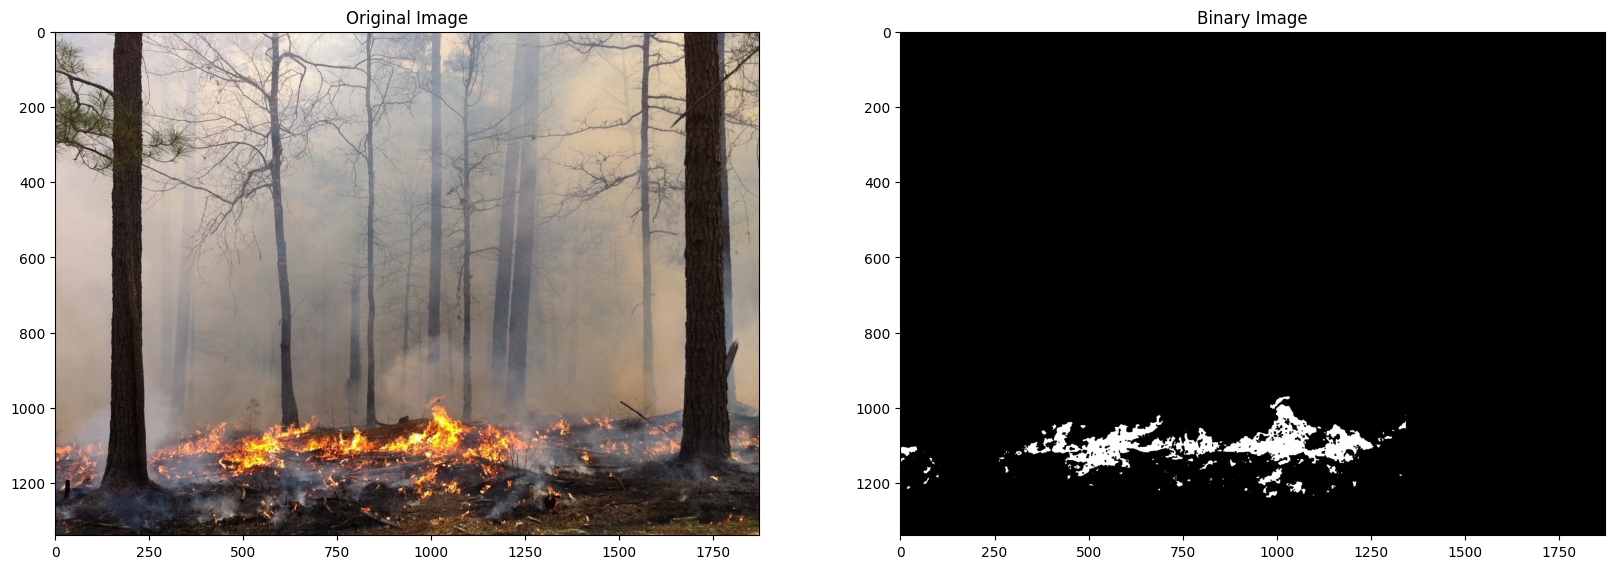

In [66]:
# Specify the path to the image
img_path = './output/original.jpg' 

# Read the image
original_image = cv.imread(img_path)

# Detect the image
binary_image = detect(img_path)

# Show the image
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(original_image[:, :, ::-1])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.show()